Switch to GPU

In [1]:
#Installs for NVIDIA GeForce RTX 3080
#pip install scikit-learn
#pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
#separately download cuda_12.3.1_546.12_windows & follow express install instructions

import torch

# Check if GPU is available
if torch.cuda.is_available():
    # Print the name of the GPU
    print(torch.cuda.get_device_name(0))
else:
    print("No GPU available, using CPU.")

NVIDIA GeForce RTX 3080


Dataset Class

In [2]:
from torch.utils.data import Dataset
import cv2

class SegmentationDataset(Dataset):
	def __init__(self, imagePaths, maskPaths, transforms):
		# store the image and mask filepaths, and augmentation
		# transforms
		self.imagePaths = imagePaths
		self.maskPaths = maskPaths
		self.transforms = transforms
  
	def __len__(self):
		# return the number of total samples contained in the dataset
		return len(self.imagePaths)

	def __getitem__(self, idx):
		# grab the image path from the current index
		imagePath = self.imagePaths[idx]
		maskPath = self.maskPaths[idx]

		# load the image from disk, swap its channels from BGR to RGB,
		# and read the associated mask from disk in grayscale mode
		image = cv2.imread(imagePath, cv2.IMREAD_UNCHANGED)
		image = (image/255).astype('uint8')
		image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
		image = image[:, :, 0]
		mask = cv2.imread(maskPath, cv2.IMREAD_UNCHANGED)
		mask = mask.astype('uint8')
  
		# check to see if we are applying any transformations
		if self.transforms is not None:
			# apply the transformations to both image and its mask
			image = self.transforms(image)
			mask = self.transforms(mask)
   
		# return a tuple of the image and its mask
		return (image, mask)

Low Depth UNET Model

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

class UNet(nn.Module):
    def __init__(self, in_ch=1, out_ch=1, dropout_prob=0.3):
        super(UNet, self).__init__()

        # Encoder
        self.conv1 = self.conv_block(in_ch, 16, 3, 1)
        self.conv2 = self.conv_block(16, 32, 3, 1)
        self.conv3 = self.conv_block(32, 64, 3, 1)
        self.conv4 = self.conv_block(64, 128, 3, 1)
        self.conv5 = self.conv_block(128, 256, 3, 1)

        self.pool = nn.MaxPool2d(2, stride=2)

        # Decoder
        self.upconv5 = self.upconv_block(256, 128, 2, 2)
        self.upconv4 = self.upconv_block(128, 64, 2, 2)
        self.upconv3 = self.upconv_block(64, 32, 2, 2)
        self.upconv2 = self.upconv_block(32, 16, 2, 2)

        self.conv4d = self.conv_block(256, 128, 3, 1)
        self.conv3d = self.conv_block(128, 64, 3, 1)
        self.conv2d = self.conv_block(64, 32, 3, 1)
        self.conv1d = self.conv_block(32, 16, 3, 1)

        self.final_conv = nn.Conv2d(16, out_ch, kernel_size=1)

        # Dropout
        self.dropout = nn.Dropout2d(p=dropout_prob)

        # Xavier initialization
        self.initialize_weights()

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.xavier_uniform_(m.weight.data)

    def conv_block(self, in_channels, out_channels, kernel_size, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def upconv_block(self, in_channels, out_channels, kernel_size, stride):
        return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride)

    def forward(self, x):
        # Encoder
        x1 = self.conv1(x)
        x2 = self.conv2(self.pool(x1))
        x3 = self.conv3(self.pool(x2))
        x4 = self.conv4(self.pool(x3))
        x5 = self.conv5(self.pool(x4))

        # Decoder
        x_d = F.relu(self.upconv5(x5))
        x_d = torch.cat([x_d, x4], dim=1)
        x_d = F.relu(self.conv4d(x_d))
        x_d = self.dropout(x_d)

        x_d = F.relu(self.upconv4(x_d))
        x_d = torch.cat([x_d, x3], dim=1)
        x_d = F.relu(self.conv3d(x_d))
        x_d = self.dropout(x_d)

        x_d = F.relu(self.upconv3(x_d))
        x_d = torch.cat([x_d, x2], dim=1)
        x_d = F.relu(self.conv2d(x_d))
        x_d = self.dropout(x_d)

        x_d = F.relu(self.upconv2(x_d))
        x_d = torch.cat([x_d, x1], dim=1)
        x_d = F.relu(self.conv1d(x_d))
        x_d = self.dropout(x_d)

        output = torch.sigmoid(self.final_conv(x_d))
        return output

Train/Test/Split DataLoader

In [4]:
from sklearn.model_selection import train_test_split
from torchvision import transforms
from imutils import paths
from torch.utils.data import DataLoader
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt
import numpy as np

# Define the directories that point to the images and the masks
image_path = 'PATH1'
mask_path = 'PATH2'

# Use path.list_images from imutils to generate sorted lists of image paths
imagePaths = sorted(list(paths.list_images(image_path)))
maskPaths = sorted(list(paths.list_images(mask_path)))

# Use sklearn train_test_split to train on 90% of the data and test on the remaining 15 percent
split = train_test_split(imagePaths, maskPaths, test_size=0.15, random_state=42)
trainImages, testImages = split[:2] # First two rows are the images
trainMasks, testMasks = split[2:] # Last two rows are the masks

# Apply transformations to the images to increase dataset diversity and training set memorization
# Convert the input tensor image to a PIL Image
# Resize the PIL Image to a fixed size of (M, M)
# Convert the PIL Image to a PyTorch tensor
# Resize must be divisible by 32
transforms_list = [transforms.ToPILImage(), 
                   transforms.Resize((128, 128)),
                   transforms.ToTensor()]
transforms_composed = transforms.Compose(transforms_list)

# Use the SegmenationDataset class to return instances of [image, mask] to feed to the dataloader
train_dataset = SegmentationDataset(imagePaths=trainImages, maskPaths=trainMasks, transforms=transforms_composed)
test_dataset = SegmentationDataset(imagePaths=testImages, maskPaths=testMasks, transforms=transforms_composed)

# Batch the training and testing data to feed into the model
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

# Initialize the model and its associated parameters, such as loss function, learning rate, regularization, and epoch number
model = UNet()
criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
num_epochs = 35

# Calculate the number of batches required to finish an epoch for the training set
# Store the iteration result in the dictionary 'H'
trainSteps = len(train_dataloader) // 64
testSteps = len(test_dataloader) // 64
H = {"train_loss": [], "test_loss": [], "train_iou": [], "test_iou": []}

# Define IoU calculation
# This is for calculating intersection over union
def calculate_iou(predicted, target):
    intersection = torch.logical_and(predicted, target).sum().item()
    union = torch.logical_or(predicted, target).sum().item()
    iou = intersection / union if union != 0 else 0.0
    return iou

# If cuda was set up correctly, you should be able to do this on GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)  # Move the model to the device

Training Loop

[INFO] EPOCH: 1/35
Train loss: 0.580207, Test loss: 0.6327
Train iou: 0.0909, Test iou: 0.0000
[INFO] EPOCH: 2/35
Train loss: 0.534868, Test loss: 0.7479
Train iou: 0.3710, Test iou: 0.2779
[INFO] EPOCH: 3/35
Train loss: 0.526955, Test loss: 0.6146
Train iou: 0.4689, Test iou: 0.6211
[INFO] EPOCH: 4/35
Train loss: 0.521126, Test loss: 0.6064
Train iou: 0.5569, Test iou: 0.6383
[INFO] EPOCH: 5/35
Train loss: 0.516100, Test loss: 0.5811
Train iou: 0.6163, Test iou: 0.7494
[INFO] EPOCH: 6/35
Train loss: 0.511840, Test loss: 0.5804
Train iou: 0.6775, Test iou: 0.0846
[INFO] EPOCH: 7/35
Train loss: 0.509854, Test loss: 0.5907
Train iou: 0.7296, Test iou: 0.0007
[INFO] EPOCH: 8/35
Train loss: 0.506014, Test loss: 0.6531
Train iou: 0.7647, Test iou: 0.0004
[INFO] EPOCH: 9/35
Train loss: 0.504487, Test loss: 0.6698
Train iou: 0.7803, Test iou: 0.0015
[INFO] EPOCH: 10/35
Train loss: 0.501444, Test loss: 0.6767
Train iou: 0.8193, Test iou: 0.0016
[INFO] EPOCH: 11/35
Train loss: 0.500913, Test lo

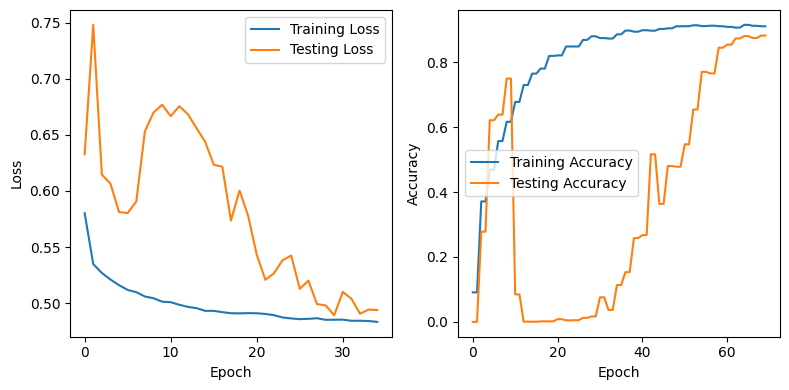

In [5]:
# Loop over epochs
for epoch in range(num_epochs):
    
    # Set model to train mode
    model.train()
    # Initialize the total training loss and correct predictions
    totalTrainLoss = 0
    train_iou = 0
    
    # Loop over the training set
    for images, masks in train_dataloader:
        # Zero the gradients
        optimizer.zero_grad()
        # Move images and masks to device
        images = images.to(device)
        masks = masks.to(device)
        # Forward pass, Backward pass, and optimization
        outputs = model(images)
        # Convert to binary mask (0 or 1) using a threshold (e.g., 0.8)
        predicted_binary = (outputs > 0.8).float()
        original_binary = (masks > 0.8).float()
        # Compute loss
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        # Update total loss
        totalTrainLoss += loss.item()
        # Calculate intersection over union
        train_iou += calculate_iou(predicted_binary, original_binary)
    
    # Calculate average training loss and iou for this epoch
    avg_train_loss = totalTrainLoss / len(train_dataloader)
    avg_train_iou = train_iou / len(train_dataloader)
    H["train_iou"].append(avg_train_iou)
    
    # Set the model to evaluation mode
    model.eval()
    # Initialize variables for testing accuracy calculation
    totalTestLoss = 0
    test_iou = 0
    
    # Loop over the testing set
    for inputs, targets in test_dataloader:
        # Move inputs and targets to device
        inputs = inputs.to(device)
        targets = targets.to(device)
        # Forward pass
        outputs = model(inputs)
        # Convert to binary mask (0 or 1) using a threshold (e.g., 0.8)
        predicted_binary = (outputs > 0.8).float()
        original_binary = (targets > 0.8).float()
        # Compute loss
        loss = criterion(outputs, targets)
        # Update total loss for validation
        totalTestLoss += loss.item()
        # Calculate intersection over union
        test_iou += calculate_iou(predicted_binary, original_binary)

    # Calculate average validation loss and accuracy for this epoch
    avg_test_loss = totalTestLoss / len(test_dataloader)
    avg_test_iou = test_iou / len(test_dataloader)
    H["test_iou"].append(avg_test_iou)
    
    # Update training history
    H["train_loss"].append(avg_train_loss)
    H["test_loss"].append(avg_test_loss)
    H["train_iou"].append(avg_train_iou)
    H["test_iou"].append(avg_test_iou)
    
    # Print training and validation information
    print("[INFO] EPOCH: {}/{}".format(epoch + 1, num_epochs))
    print("Train loss: {:.6f}, Test loss: {:.4f}".format(avg_train_loss, avg_test_loss))
    print("Train iou: {:.4f}, Test iou: {:.4f}".format(avg_train_iou, avg_test_iou))

# Create subplots for loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# Plot the training and testing losses
ax1.plot(H["train_loss"], label='Training Loss')
ax1.plot(H["test_loss"], label='Testing Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot the training and testing accuracies
ax2.plot(H["train_iou"], label='Training Accuracy')
ax2.plot(H["test_iou"], label='Testing Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

Visualize Test Set Segmentation Results

Text(0.5, 1.0, 'Predicted Binary Mask')

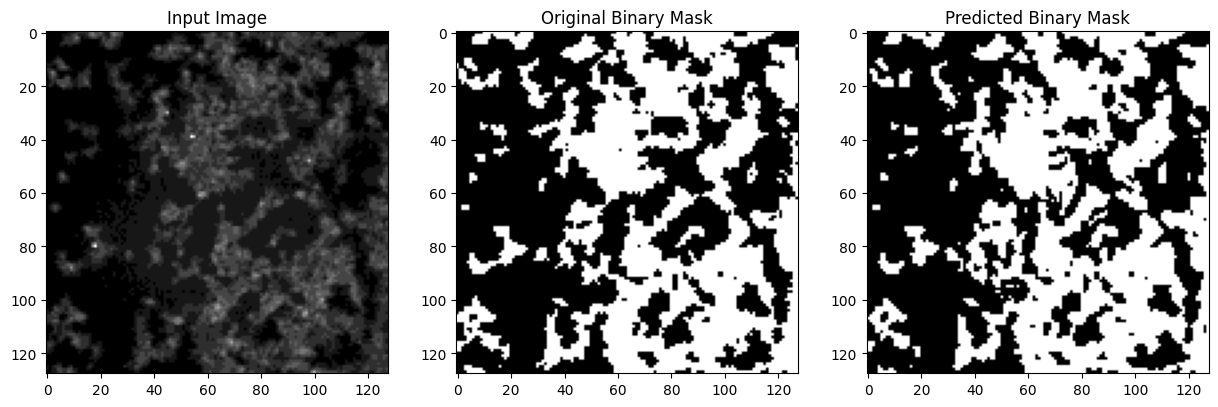

In [7]:
import random
import string
# Visualize all training set examples and save results
# Loop over the testing set
for inputs, targets in test_dataloader:
    # Move inputs and targets to device
    inputs = inputs.to(device)
    targets = targets.to(device)
    # Forward pass
    outputs = model(inputs)
    # Convert to binary mask (0 or 1) using a threshold (e.g., 0.8)
    predicted_binary = (outputs > 0.8).float()
    original_binary = (targets > 0.8).float()
    # Compute loss
    loss = criterion(outputs, targets)
    # Update total loss for validation
    totalTestLoss += loss.item()
    # Calculate intersection over union
    test_iou += calculate_iou(predicted_binary, original_binary)
    # Convert tensors to numpy arrays
    inputs_np = inputs.cpu().detach().numpy()
    original_binary_np = original_binary.cpu().detach().numpy()
    predicted_binary_np = predicted_binary.cpu().detach().numpy()
    # Reshape arrays
    inputs_np = np.squeeze(inputs_np, axis=1)
    original_binary_np = np.squeeze(original_binary_np, axis=1)
    predicted_binary_np = np.squeeze(predicted_binary_np, axis=1)
    # Plot each image and save as png
    for i in range(inputs_np.shape[0]):
        random_string = ''.join(random.choices(string.ascii_letters + string.digits, k=40))
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        ax[0].imshow(inputs_np[i], cmap='gray')
        ax[0].set_title('Input Image')
        ax[1].imshow(original_binary_np[i], cmap='gray')
        ax[1].set_title('Original Binary Mask')
        ax[2].imshow(predicted_binary_np[i], cmap='gray')
        ax[2].set_title('Predicted Binary Mask')
        #plt.savefig(f'PATH/{random_string}.png')
        plt.close()

# Display a random result
randnum = random.randint(0, inputs_np.shape[0])
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(inputs_np[randnum], cmap='gray')
ax[0].set_title('Input Image')
ax[1].imshow(original_binary_np[randnum], cmap='gray')
ax[1].set_title('Original Binary Mask')
ax[2].imshow(predicted_binary_np[randnum], cmap='gray')
ax[2].set_title('Predicted Binary Mask')